## Optimising SandyCo's Sand Distribution with Direct Shipping

**Problem Background:**
- SandyCo still has two facilities that mine, clean, and sort sand for use in cement, children’s playboxes, and small beaches. They have added two packaging centres to the network. The sand now moves from the plants to the packaging centres and then to the regions.
- Each plant has a specific maximum weekly supply of available sand and each region has an expected minimum weekly required demand. The cost to distribute a tonne of sand differs between each plant, packaging centre, and region combination due to distance and other factors.

**Problem Objective:**
- How much sand should SandyCo ship from each plant to each packaging centre and then to each region each week to meet demand at the lowest planned distribution costs?

**New Scenario:**
- The management of Plant 2 has suggested they may use some of the available space in the plant for an on-site packaging machine. With such a machine in place, Plant 2 would be able to bypass the packaging centres and ship directly to Region 1. Direct transport from Plant 2 to Region 1 costs £275 per tonne. All other costs remain the same as in Part 2.

**Question:**
- If Plant 2 invests in an on-site sand packaging machine, how many tonnes of sand should be delivered directly from Plant 2 to Region 1?

### Model Formulation

To accommodate the new direct route from Plant 2 to Region 1, we need to adjust the transhipment problem formulation as follows:

**Indices:**
- \(i\) = Origin index (plant, packaging centre)
- \(j\) = Destination index (packaging centre, region)

**Decision Variables:**
- \(x_{ij}\) = Amount of goods transported from origin \(i\) to destination \(j\)
- \(x_{\text{P2}, \text{R1}}\) = Amount of goods transported directly from Plant 2 to Region 1

**Parameters:**
- \(S_i\) = Supply capacity of plant \(i\)
- \(D_j\) = Demand requirement of region \(j\)
- \(c_{ij}\) = Cost of transporting one unit of goods from origin \(i\) to destination \(j\)
- \(c_{\text{P2}, \text{R1}} = 275\) = Cost of transporting one unit of goods directly from Plant 2 to Region 1

**Objective Function:**
$$\min z: \sum_{i} \sum_{j} c_{ij} x_{ij} + c_{\text{P2}, \text{R1}} x_{\text{P2}, \text{R1}}$$

**Constraints:**
1. Supply constraints:
$$\sum_{j} x_{ij} + (x_{\text{P2}, \text{R1}} \text{ if } i = \text{P2} \text{ else } 0) \leq S_i \quad \forall i \in \text{plants}$$

2. Demand constraints:
$$\sum_{i} x_{ij} + (x_{\text{P2}, \text{R1}} \text{ if } j = \text{R1} \text{ else } 0) \geq D_j \quad \forall j \in \text{regions}$$

3. Transhipment (flow conservation) constraints:
$$\sum_{i} x_{ij} = \sum_{k} x_{jk} \quad \forall j \in \text{packaging centres}$$

4. Non-negativity constraints:
$$x_{ij} \geq 0 \quad \forall i, j$$
$$x_{\text{P2}, \text{R1}} \geq 0$$

This updated model formulation includes the new direct route from Plant 2 to Region 1, ensuring that the supply and demand constraints are adjusted accordingly to incorporate this additional route.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jonathanduquegonzalez/myenv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/lz/hqm78w6x12b2gll67jmrwpn00000gn/T/1acebf161d8042bea622da9e15747514-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/lz/hqm78w6x12b2gll67jmrwpn00000gn/T/1acebf161d8042bea622da9e15747514-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 46 RHS
At line 54 BOUNDS
At line 55 ENDATA
Problem MODEL has 7 rows, 11 columns and 22 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7 (0) rows, 11 (0) columns and 22 (0) elements
0  Obj 0 Primal inf 200 (3)
6  Obj 56700
Optimal - objective value 56700
Optimal objective 56700 - 6 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01



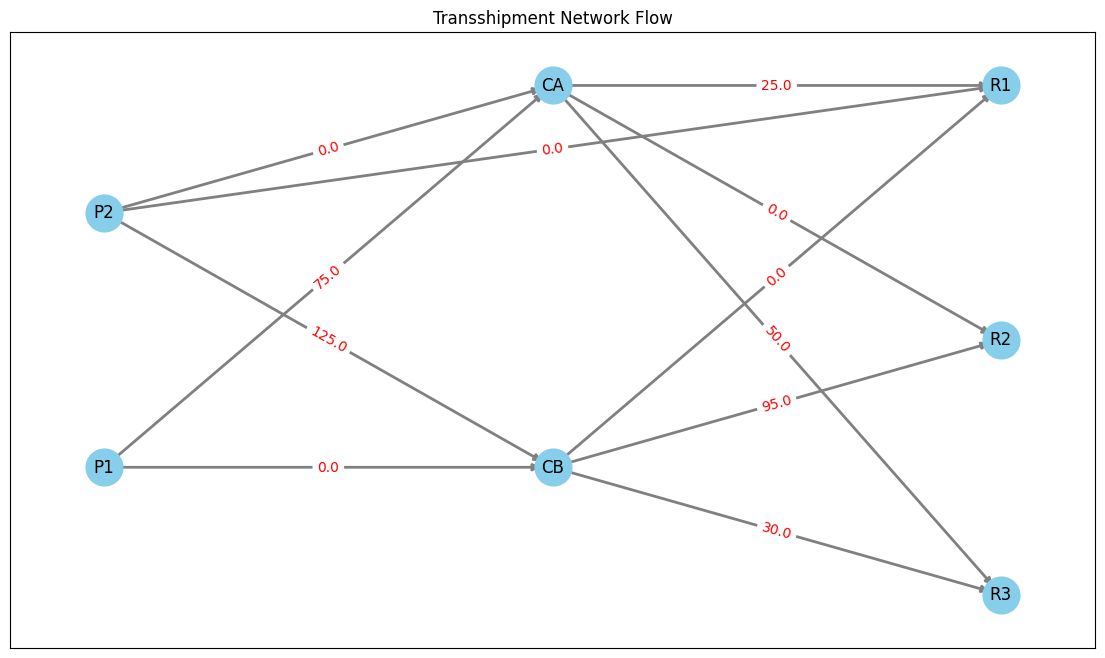

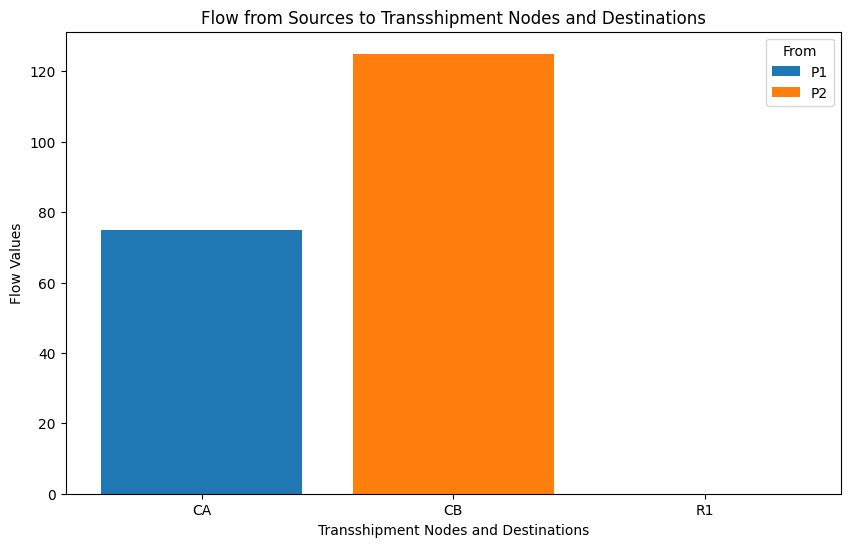

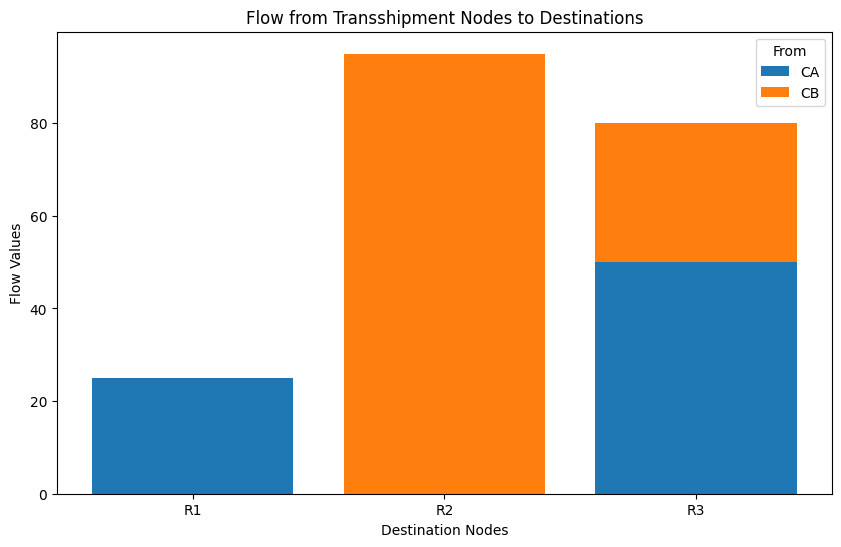


Total Cost:
56700.0


,Variable,Value
0,flow_CA_R1,25.0
1,flow_CA_R2,0.0
2,flow_CA_R3,50.0
3,flow_CB_R1,0.0
4,flow_CB_R2,95.0
5,flow_CB_R3,30.0
6,flow_P1_CA,75.0
7,flow_P1_CB,0.0
8,flow_P2_CA,0.0
9,flow_P2_CB,125.0


In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pulp

def solve_transshipment_problem_updated(nodes, supply, demand, cost, new_route, plot_network=False, plot_bar_chart=False):
    """
    Solves the updated transhipment problem given nodes, supply, demand, cost data, and a new direct route.
    Optionally plots the transhipment network and a stacked bar chart.

    Parameters:
    nodes (dict): Dictionary containing lists of source nodes, transhipment nodes, and destination nodes.
    supply (dict): Supply values for each source node.
    demand (dict): Demand values for each destination node.
    cost (dict): Cost of transportation between nodes.
    new_route (tuple): Tuple containing new direct route (origin, destination) and its cost.
    plot_network (bool): Whether to plot the transhipment network. Default is False.
    plot_bar_chart (bool): Whether to plot the stacked bar chart. Default is False.

    Returns:
    results_df (pd.DataFrame): DataFrame containing the flow values.
    total_cost (float): Total cost of the solution.
    flow (dict): Flow values between nodes as decision variables from the optimisation result.
    """
    sources = nodes['sources']
    transshipments = nodes['transshipments']
    destinations = nodes['destinations']

    # Define the problem
    problem = pulp.LpProblem("Transshipment_Problem", pulp.LpMinimize)

    # Decision variables
    flow = {(i, j): pulp.LpVariable(f"flow_{i}_{j}", lowBound=0, cat='Continuous') for (i, j) in cost}
    flow[new_route[:2]] = pulp.LpVariable(f"flow_{new_route[0]}_{new_route[1]}", lowBound=0, cat='Continuous')

    # Objective function
    problem += pulp.lpSum(cost[i, j] * flow[i, j] for (i, j) in cost) + new_route[2] * flow[new_route[:2]], "Total Cost"

    # Supply constraints
    for i in sources:
        problem += pulp.lpSum(flow[i, j] for j in transshipments) + (flow[new_route[:2]] if i == new_route[0] else 0) <= supply[i], f"Supply_{i}"

    # Demand constraints
    for j in destinations:
        problem += pulp.lpSum(flow[i, j] for i in transshipments) + (flow[new_route[:2]] if j == new_route[1] else 0) >= demand[j], f"Demand_{j}"

    # Transshipment constraints
    for k in transshipments:
        problem += pulp.lpSum(flow[i, k] for i in sources) == pulp.lpSum(flow[k, j] for j in destinations), f"Transshipment_{k}"

    # Solve the problem
    problem.solve()

    # Store results in DataFrame
    results = [(v.name, v.varValue) for v in problem.variables()]
    results_df = pd.DataFrame(results, columns=['Variable', 'Value'])

    # Extract total cost
    total_cost = pulp.value(problem.objective)

    # Optionally plot the network
    if plot_network:
        plot_transshipment_network(nodes, cost, flow, new_route)

    # Optionally plot the stacked bar chart
    if plot_bar_chart:
        plot_stacked_bar_chart(flow, nodes, new_route)
    
    return results_df, total_cost, flow

def plot_transshipment_network(nodes, cost, flow, new_route):
    """
    Plots the transhipment network with the given nodes, cost, and flow values.

    Parameters:
    nodes (dict): Dictionary containing lists of source nodes, transhipment nodes, and destination nodes.
    cost (dict): Cost of transportation between nodes.
    flow (dict): Flow values between nodes as decision variables from the optimisation result.
    new_route (tuple): Tuple containing new direct route (origin, destination) and its cost.
    """
    sources = nodes['sources']
    transshipments = nodes['transshipments']
    destinations = nodes['destinations']

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    for node in sources + transshipments + destinations:
        G.add_node(node)

    # Add edges with weights
    for (i, j) in cost:
        G.add_edge(i, j, weight=cost[i, j], capacity=flow[i, j].varValue)

    # Add the new direct route edge
    if new_route[:2] in flow:
        G.add_edge(new_route[0], new_route[1], weight=new_route[2], capacity=flow[new_route[:2]].varValue)

    # Custom positions for the nodes
    pos = {
        'P1': (0, 0), 'P2': (0, 2),
        'CA': (1, 3), 'CB': (1, 0),
        'R1': (2, 3), 'R2': (2, 1), 'R3': (2, -1)
    }

    # Draw the network graph
    plt.figure(figsize=(14, 8))  # Adjust the figure size as needed
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Draw edge labels with the flow values
    edge_labels = {(i, j): f"{flow[i, j].varValue:.1f}" for (i, j) in cost}
    if new_route[:2] in flow:
        edge_labels[new_route[:2]] = f"{flow[new_route[:2]].varValue:.1f}"
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title('Transshipment Network Flow')
    plt.show()

def plot_stacked_bar_chart(flow, nodes, new_route):
    """
    Plots a stacked bar chart showing the flow values between nodes.

    Parameters:
    flow (dict): Flow values between nodes as decision variables from the optimisation result.
    nodes (dict): Dictionary containing lists of source nodes, transhipment nodes, and destination nodes.
    new_route (tuple): Tuple containing new direct route (origin, destination) and its cost.
    """
    sources = nodes['sources']
    transshipments = nodes['transshipments']
    destinations = nodes['destinations']

    # Create a DataFrame to hold flow values for plotting
    flow_data = {
        'From': [],
        'To': [],
        'Flow': []
    }

    for (i, j), var in flow.items():
        flow_data['From'].append(i)
        flow_data['To'].append(j)
        flow_data['Flow'].append(var.varValue)

    flow_df = pd.DataFrame(flow_data)

    # Create separate DataFrames for each category
    flow_sources_to_transshipments = flow_df[flow_df['From'].isin(sources)]
    flow_transshipments_to_destinations = flow_df[flow_df['From'].isin(transshipments)]

    # Adjust for new route in the data
    if new_route[0] in sources and new_route[1] in destinations:
        new_route_df = pd.DataFrame({'From': [new_route[0]], 'To': [new_route[1]], 'Flow': [flow[new_route[:2]].varValue]})
        flow_sources_to_transshipments = pd.concat([flow_sources_to_transshipments, new_route_df], ignore_index=True)

    # Plot the stacked bar chart for sources to transshipments
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bottom = pd.Series([0] * (len(transshipments) + len(destinations)), index=transshipments + destinations)
    for source in sources:
        values = flow_sources_to_transshipments[flow_sources_to_transshipments['From'] == source].set_index('To')['Flow']
        ax.bar(values.index, values, bottom=bottom[values.index], label=source)
        bottom[values.index] += values

    ax.set_xlabel('Transshipment Nodes and Destinations')
    ax.set_ylabel('Flow Values')
    ax.set_title('Flow from Sources to Transshipment Nodes and Destinations')
    ax.legend(title='From')

    plt.show()

    # Plot the stacked bar chart for transshipments to destinations
    fig, ax = plt.subplots(figsize=(10, 6))

    bottom = pd.Series([0] * len(destinations), index=destinations)
    for transshipment in transshipments:
        values = flow_transshipments_to_destinations[flow_transshipments_to_destinations['From'] == transshipment].set_index('To')['Flow']
        ax.bar(destinations, values, bottom=bottom[destinations], label=transshipment)
        bottom += values

    ax.set_xlabel('Destination Nodes')
    ax.set_ylabel('Flow Values')
    ax.set_title('Flow from Transshipment Nodes to Destinations')
    ax.legend(title='From')

    plt.show()

# Example usage:
nodes = {
    'sources': ['P1', 'P2'],
    'transshipments': ['CA', 'CB'],
    'destinations': ['R1', 'R2', 'R3']
}

supply = {'P1': 100, 'P2': 125}
demand = {'R1': 25, 'R2': 95, 'R3': 80}
cost = {
    ('P1', 'CA'): 190, ('P1', 'CB'): 210,
    ('P2', 'CA'): 185, ('P2', 'CB'): 105,
    ('CA', 'R1'): 175, ('CA', 'R2'): 180, ('CA', 'R3'): 165,
    ('CB', 'R1'): 235, ('CB', 'R2'): 130, ('CB', 'R3'): 145
}

new_route = ('P2', 'R1', 275)

# Solve the problem, store results in DataFrame, and plot the network and bar chart
results_df, total_cost, flow = solve_transshipment_problem_updated(nodes, supply, demand, cost, new_route, plot_network=True, plot_bar_chart=True)

print("\nTotal Cost:")
print(total_cost)

results_df

### Key Insights:

1. **Total Cost**:
   - The total cost remains at 56700.0 units of currency, indicating that the direct route from Plant 2 to Region 1 did not reduce the overall cost.

2. **Unused Direct Route**:
   - The direct route from Plant 2 to Region 1 is not utilised, as indicated by `flow_P2_R1` being 0.0. This suggests that it is not cost-effective under the current cost structure.

3. **Supply and Demand Fulfillment**:
   - All supply and demand constraints are met, with the total supply from P1 and P2 matching their capacities and the total demand across R1, R2, and R3 being fulfilled.

### Recommendations:

1. **Re-evaluate Direct Route Costs**:
   - Consider reducing the cost for the direct route from Plant 2 to Region 1 to make it a viable option.

2. **Explore Other Direct Routes**:
   - Assess if direct routes from other plants to regions could offer cost advantages.

3. **Scenario Analysis**:
   - Conduct further scenario analysis with varying supply and demand configurations to explore the benefits of direct routes.

4. **Cost-Benefit Analysis**:
   - Perform a detailed cost-benefit analysis of the on-site packaging machine at Plant 2, considering potential savings in handling, time, and operational efficiencies.

By implementing these recommendations, SandyCo can optimise their supply chain network, potentially lowering transportation costs and improving efficiency.